# Create Records  Tutorial

In [3]:
cd /home/users/cdonoso/rnn_classifier/

/home/users/cdonoso/rnn_classifier


In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from core.data import create_dataset
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
metadata = pd.read_csv('./data/raw_data/ztf_forced/metadata.csv')
metadata = metadata.replace({'EB/EW':'EB&EW', 'CV/Nova':'CV&Nova'})
metadata.sample(1)

,oid,ra,dec,submitter,alerceclass,partition
77021,ZTF20aaayaet,134.217718,53.794479,jsilva,SNIa,validation_1


In [6]:
metadata['alerceclass'].unique()

array(['AGN', 'Blazar', 'CVNova', 'Ceph', 'DSCT', 'EA', 'EBEW', 'LPV',
       'Periodic-Other', 'QSO', 'RRLab', 'RRLc', 'RSCVn', 'SNIa', 'YSO',
       'nonSNIa'], dtype=object)

In [7]:
transient = ['SNIa', 'nonSNIa']#['SNIa', 'SNIbc', 'SNII', 'SNIIn', 'SNIIb', 'SLSN', 'TDE']
stochastic = ['QSO', 'AGN', 'Blazar', 'CVNova', 'YSO'] 
periodic = ['LPV', 'RSCVn', 'Ceph', 'EA', 'EBEW', 'RRLc', 'RRLab', 'DSCT', 'Periodic-Other']

In [72]:
change = {'SNIa':'Transient', 'nonSNIa':'Transient', 'QSO':'Stochastic', 'AGN':'Stochastic', 
 'Blazar':'Stochastic', 'CVNova':'Stochastic', 'YSO':'Stochastic', 
 'LPV':'Periodic', 'RSCVn':'Periodic', 'Ceph':'Periodic', 'EA':'Periodic', 
 'EBEW':'Periodic', 'RRLc':'Periodic', 'RRLab':'Periodic', 'DSCT':'Periodic', 'Periodic-Other':'Periodic'}

In [9]:
# metadata['alerceclass'] = metadata['alerceclass'].replace(change)

In [11]:
class_names =transient+stochastic+periodic
class_names

['SNIa',
 'nonSNIa',
 'QSO',
 'AGN',
 'Blazar',
 'CVNova',
 'YSO',
 'LPV',
 'RSCVn',
 'Ceph',
 'EA',
 'EBEW',
 'RRLc',
 'RRLab',
 'DSCT',
 'Periodic-Other']

# Reading observations

In [12]:
%%time
observations = pd.read_csv('./data/raw_data/ztf_forced/detections.csv')

CPU times: user 8.44 s, sys: 663 ms, total: 9.11 s
Wall time: 9.11 s


In [13]:
observations.sample(2)

,oid,index,forcediffimflux,forcediffimfluxunc,forcediffimsnr,mjd,fid,flux_diff_ujy,sigma_flux_diff_ujy
5225795,ZTF18ababjtc,1505,22474.961764,108.863458,229.652744,58975.472407,1,2412.231373,11.684285
8310618,ZTF18acaxqcg,155,130.263870,35.092423,4.129195,58235.491782,1,15.413596,4.152344


# Writting records

In [15]:
test_df = metadata[metadata['partition'] == 'test']

In [20]:
%%time
for fold_n in range(3):
    os.makedirs('data/records/forced/fold_{}'.format(fold_n), exist_ok=True)
    test_df.to_csv('data/records/forced/fold_{}/test_samples.csv'.format(fold_n), index=False)
    
    create_dataset(metadata[metadata['partition'] == 'training_{}'.format(fold_n)], 
                   observations,
                   target='data/records/forced/fold_{}/train'.format(fold_n),
                   n_jobs = 8,
                   unique_labels=class_names)
    
    create_dataset(metadata[metadata['partition'] == 'validation_{}'.format(fold_n)], 
                   observations,
                   target='data/records/forced/fold_{}/val'.format(fold_n),
                   n_jobs = 8,
                   unique_labels=class_names)
    
    create_dataset(test_df, 
                   observations,
                   target='data/records/forced/fold_{}/test'.format(fold_n),
                   n_jobs = 8,
                   unique_labels=class_names)

[INFO] Preprocessing lighcurves...


100%|███████████████████████████████████| 14481/14481 [00:12<00:00, 1148.38it/s]


[INFO] Preprocessing lighcurves...


100%|█████████████████████████████████████| 1609/1609 [00:01<00:00, 1160.63it/s]


[INFO] Preprocessing lighcurves...


100%|█████████████████████████████████████| 1600/1600 [00:01<00:00, 1145.99it/s]


[INFO] Preprocessing lighcurves...


100%|███████████████████████████████████| 14481/14481 [00:12<00:00, 1140.79it/s]


[INFO] Preprocessing lighcurves...


100%|█████████████████████████████████████| 1609/1609 [00:01<00:00, 1187.78it/s]


[INFO] Preprocessing lighcurves...


100%|█████████████████████████████████████| 1600/1600 [00:01<00:00, 1150.80it/s]


[INFO] Preprocessing lighcurves...


100%|███████████████████████████████████| 14481/14481 [00:12<00:00, 1148.32it/s]


[INFO] Preprocessing lighcurves...


100%|█████████████████████████████████████| 1609/1609 [00:01<00:00, 1155.64it/s]


[INFO] Preprocessing lighcurves...


100%|█████████████████████████████████████| 1600/1600 [00:01<00:00, 1159.86it/s]

CPU times: user 1min 14s, sys: 4.59 s, total: 1min 18s
Wall time: 1min 20s


# Reading records

In [26]:
from core.data import load_records
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
test_df = pd.read_csv('./data/records/forced/fold_0/test_samples.csv')
num_classes = len(metadata['alerceclass'].unique())

In [30]:
dataset = load_records('./data/records/forced/fold_0/test/', batch_size=256, 
                       max_obs=200, num_classes=num_classes, 
                       sampling=False, shuffle=True)

(200, 3)


2021-11-25 22:57:34.903669: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


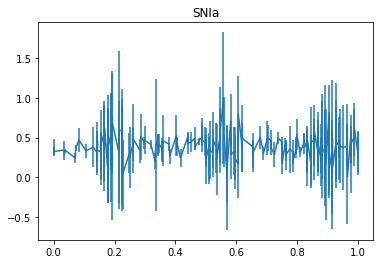

In [31]:
for x, y in dataset:
    sample = x['input'][0]
    print(sample.shape)
    plt.errorbar(sample[:, 0], sample[:, 1], yerr=sample[:, 2])
    plt.title('{}'.format(class_names[np.argmax(y[0], 0)]))
    break

In [35]:
x['id'][0]

<tf.Tensor: shape=(), dtype=string, numpy=b'ZTF20abccojn'>